In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
from core.config import *

from core.datasets import VOC2012SegDataset
from core.data import crop_augment_preprocess_batch
from core.data_utils import flatten_list_of_lists
from core.color_map import apply_colormap
from core.torch_utils import get_activation
from models.seg import SEGMODELS_REGISTRY
from core.viz import normalize_sim_maps, viz_seg_saliency_maps

import torch.nn.functional as F
import torchvision.transforms.v2 as T
from torchvision.transforms._presets import SemanticSegmentation
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.hooks import RemovableHandle

from collections import OrderedDict
from functools import partial

In [3]:
config = setup_config(BASE_CONFIG, Path('/home/olivieri/exp/src/viz/seg/viz_config.yml'))
seg_config = config['seg']

In [4]:
segmodel = SEGMODELS_REGISTRY.get(
    'lraspp_mobilenet_v3_large',
    pretrained_weights_path=seg_config['pretrained_weights_path'],
    device=config['device'],
    adaptation=seg_config['adaptation']
)

In [5]:
if seg_config['checkpoint_path']:
    state_dict: OrderedDict = torch.load(seg_config['checkpoint_path'])
    model_state_dict = state_dict.get('model_state_dict', state_dict)
    segmodel.model.load_state_dict(model_state_dict)

In [6]:
img_idxs = np.random.choice(range(0, 80), size=10, replace=False).tolist() # reproducible
assert 16 not in img_idxs # one-shot example
img_idxs, len(img_idxs)

([30, 0, 22, 31, 18, 28, 10, 70, 4, 12], 10)

`img_idxs` should be array([30,  0, 22, 31, 18, 28, 10, 70,  4, 12]).

In [7]:
viz_ds = VOC2012SegDataset(
    root_path=config['datasets']['VOC2012_root_path'],
    split='prompts_split',
    device=config['device'],
    resize_size=config['seg']['image_size'],
    center_crop=True,
    img_idxs=img_idxs,
    with_unlabelled=False
)

In [8]:
viz_collate_fn = partial(
    crop_augment_preprocess_batch,
    crop_fn=T.CenterCrop(seg_config['image_size']),
    augment_fn=None,
    preprocess_fn=None
)

In [9]:
viz_dl = DataLoader(
    viz_ds,
    batch_size=seg_config['batch_size'],
    shuffle=False,
    generator=get_torch_gen(),
    collate_fn=viz_collate_fn,
)

In [10]:
handles: list[RemovableHandle] = list()
activations: dict[str, torch.Tensor] = dict()

In [11]:
target_layer: nn.Module = segmodel.model.backbone['16'] # (B, 960, 33, 33) bottleneck output
handle = target_layer.register_forward_hook(get_activation('target_layer_act', activations))
segmodel.add_handle(handle)

In [27]:
class_idx_to_name = {idx: name for idx, name in enumerate(viz_ds.get_classes())}
class_idx_to_name

{0: 'BACKGROUND',
 1: 'AEROPLANE',
 2: 'BICYCLE',
 3: 'BIRD',
 4: 'BOAT',
 5: 'BOTTLE',
 6: 'BUS',
 7: 'CAR',
 8: 'CAT',
 9: 'CHAIR',
 10: 'COW',
 11: 'DININGTABLE',
 12: 'DOG',
 13: 'HORSE',
 14: 'MOTORBIKE',
 15: 'PERSON',
 16: 'POTTEDPLANT',
 17: 'SHEEP',
 18: 'SOFA',
 19: 'TRAIN',
 20: 'TVMONITOR'}

In [28]:
target_classes = list(
    [
        [8, 1, 14, 15, 13],
        [15, 15, 10, 4, 20]
    ]
) # should be (num_batches, batch size)

flat_target_classes, target_classes_struct_info = flatten_list_of_lists(target_classes)
flat_target_class_names = [class_idx_to_name[class_idx] for class_idx in flat_target_classes]

In [14]:
cams_: list[torch.tensor] = []
bck_imgs_: list[torch.tensor] = []
gt_masks_: list[torch.tensor] = []
pr_masks_: list[torch.tensor] = []

for step, (scs_img, gts) in enumerate(viz_dl):
    scs = segmodel.preprocess_images(scs_img)
    scs.requires_grad_(True)

    scs: torch.Tensor = scs.to(config['device'])
    gts: torch.Tensor = gts.to(config['device']) # (B, H, W)

    logits = segmodel.model(scs)
    logits: torch.Tensor = logits["out"] if isinstance(logits, OrderedDict) else logits # (B, C, H, W)

    [print(f"{step*viz_dl.batch_size + i}: {gt.unique()}") for i, gt in enumerate(gts)]

    feature_volume: torch.Tensor = activations['target_layer_act'] # (B, 960, 33, 33)

    cams_b = segmodel.compute_seg_grad_cam_map(
        feature_volume,
        logits,
        target_classes[step]
    )

    cams_.extend(torch.unbind(cams_b))
    bck_imgs_.extend(torch.unbind(scs_img))
    gt_masks_.extend(torch.unbind(gts))
    pr_masks_.extend(torch.unbind(logits.argmax(dim=1)))

cams = torch.stack(cams_)
bck_imgs = torch.stack(bck_imgs_)
gt_masks = torch.stack(gt_masks_)
pr_masks = torch.stack(pr_masks_)
cams.shape, bck_imgs.shape, gt_masks.shape, pr_masks.shape

0: tensor([0, 8], device='cuda:0')
1: tensor([ 0,  1, 15], device='cuda:0')
2: tensor([ 0, 14, 15], device='cuda:0')
3: tensor([ 0, 15], device='cuda:0')
4: tensor([ 0, 13], device='cuda:0')
5: tensor([ 0, 15], device='cuda:0')
6: tensor([ 0,  5, 15], device='cuda:0')
7: tensor([ 0, 10], device='cuda:0')
8: tensor([0, 4], device='cuda:0')
9: tensor([ 0, 20], device='cuda:0')


(torch.Size([10, 33, 33]),
 torch.Size([10, 3, 520, 520]),
 torch.Size([10, 520, 520]),
 torch.Size([10, 520, 520]))

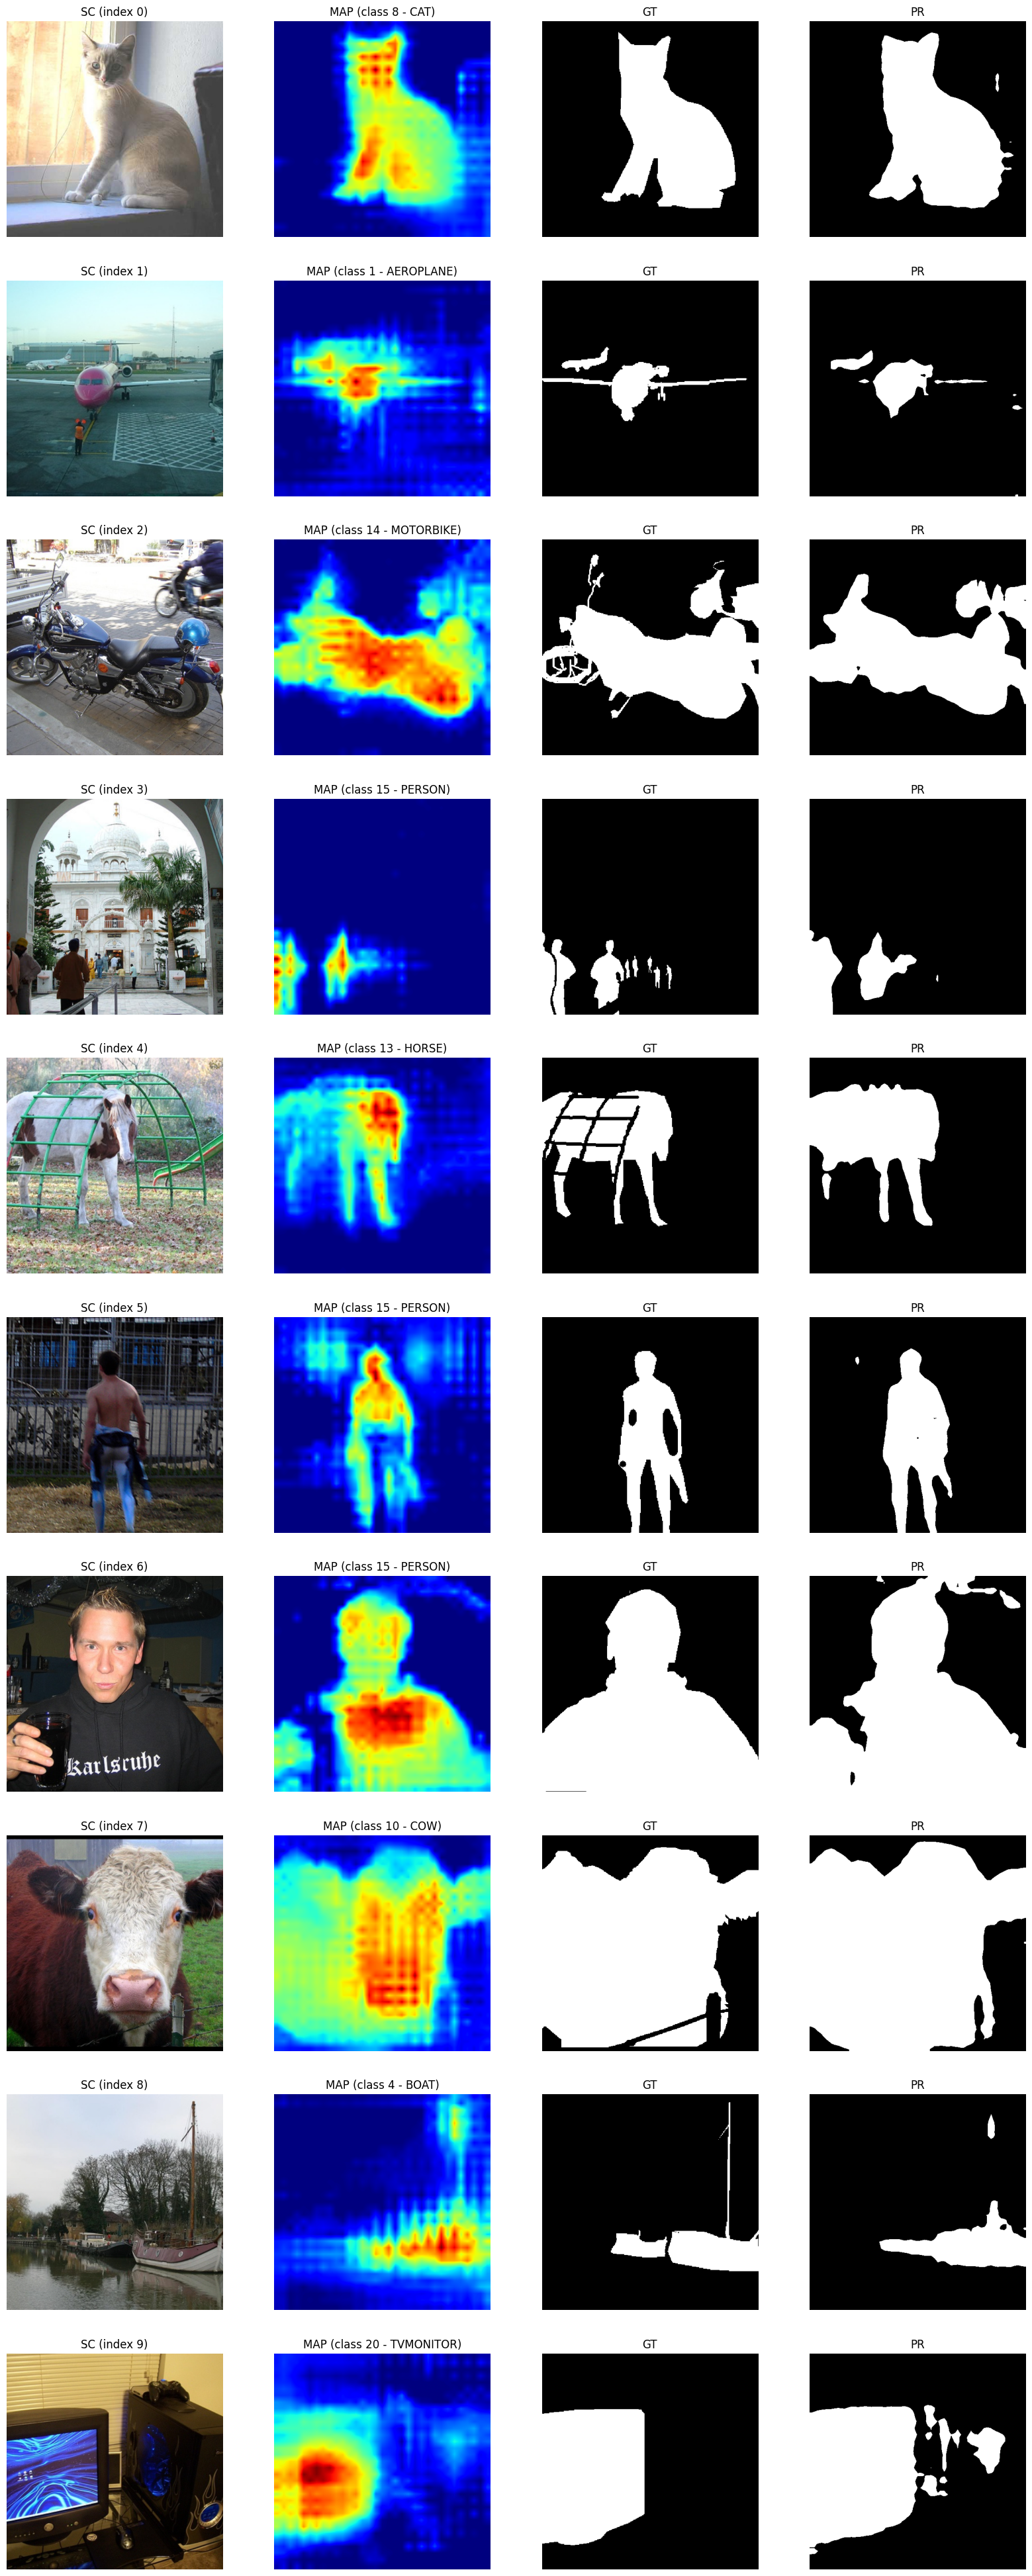

In [35]:
fig = viz_seg_saliency_maps(
    bck_imgs,
    cams,
    flat_target_classes,
    flat_target_class_names,
    gt_masks,
    pr_masks,
    alpha=0.5
)

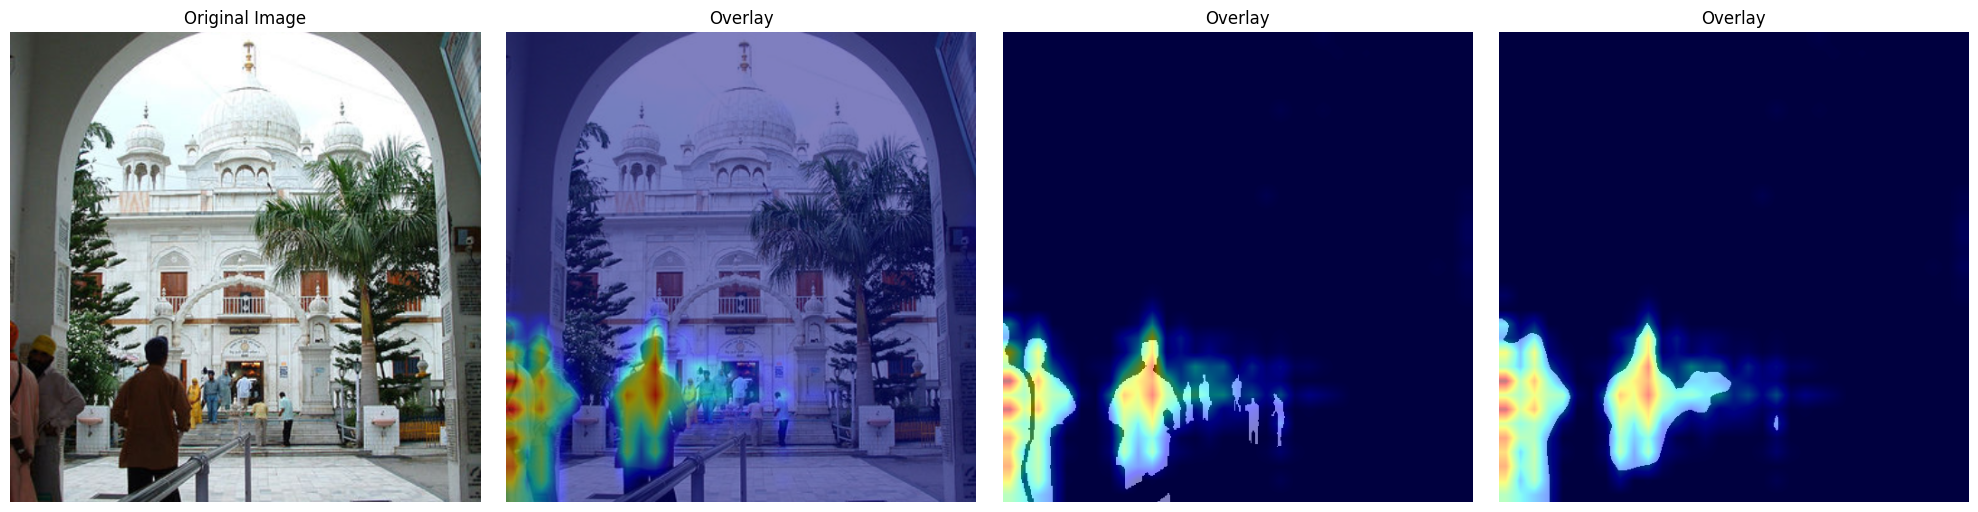

In [15]:
# Visualize Grad-CAM heatmap overlay
import matplotlib.pyplot as plt
import matplotlib.cm as cm

cams_normalized = normalize_sim_maps(cams)

cams_upsampled = F.interpolate(
        cams_normalized.unsqueeze(1), # (B, 1, H_viz, W_viz)
        size=config['viz_image_size'],
        mode='bilinear',
).squeeze(1) # (B, H_viz, W_viz)
bck_img_upsampled = F.interpolate(bck_imgs, size=cams_upsampled.shape[-2:], mode='bilinear') # (B, 3, H_viz, W_viz)
# gt_imgs = apply_colormap(gt_masks.unsqueeze(1), viz_ds.get_color_map_dict())
gt_imgs = (gt_masks == torch.tensor(flat_target_classes, device=gt_masks.device).view(-1, 1, 1)).unsqueeze(1).expand(-1, 3, -1, -1)*1.0
pr_imgs = (pr_masks == torch.tensor(flat_target_classes, device=pr_masks.device).view(-1, 1, 1)).unsqueeze(1).expand(-1, 3, -1, -1)*1.0


# Select the first image in the batch
img_idx = 3
bck_img = bck_img_upsampled[img_idx].permute(1, 2, 0).cpu().numpy()  # [H_viz, W_viz, C]
gt_img = gt_imgs[img_idx].permute(1, 2, 0).cpu().numpy()  # [H_viz, W_viz, C]
pr_img = pr_imgs[img_idx].permute(1, 2, 0).cpu().numpy()  # [H_viz, W_viz, C]
cam_heatmap = cams_upsampled[img_idx].detach().cpu().numpy()  # [H_viz, W_viz]

# Create figure with subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 1. Original image
axes[0].imshow(bck_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# 2. Overlay: blend original image with heatmap
# Convert heatmap to RGB using jet colormap
heatmap_colored = cm.jet(cam_heatmap)[:, :, :3]  # Remove alpha channel
# Blend with original image (alpha blending)
alpha = 0.5
overlay = bck_img * (1 - alpha) + heatmap_colored * alpha
overlay = np.clip(overlay, 0, 1)  # Ensure values are in [0, 1]

axes[1].imshow(overlay)
axes[1].set_title('Overlay')
axes[1].axis('off')

# 3. Overlay: blend original image with heatmap
# Convert heatmap to RGB using jet colormap
heatmap_colored = cm.jet(cam_heatmap)[:, :, :3]  # Remove alpha channel
# Blend with original image (alpha blending)
alpha = 0.5
overlay = gt_img * (1 - alpha) + heatmap_colored * alpha
overlay = np.clip(overlay, 0, 1)  # Ensure values are in [0, 1]

axes[2].imshow(overlay)
axes[2].set_title('Overlay')
axes[2].axis('off')

# 4. Overlay: blend original image with heatmap
# Convert heatmap to RGB using jet colormap
heatmap_colored = cm.jet(cam_heatmap)[:, :, :3]  # Remove alpha channel
# Blend with original image (alpha blending)
alpha = 0.5
overlay = pr_img * (1 - alpha) + heatmap_colored * alpha
overlay = np.clip(overlay, 0, 1)  # Ensure values are in [0, 1]

axes[3].imshow(overlay)
axes[3].set_title('Overlay')
axes[3].axis('off')

# # CAM heatmap
# heatmap = axes[2].imshow(cam_heatmap, cmap='jet')
# axes[2].set_title('Grad-CAM Heatmap')
# axes[2].axis('off')
# plt.colorbar(heatmap, ax=axes[2])

plt.tight_layout()
plt.show()

# OLD

---

In [ ]:
seg_preprocess_fn = partial(SemanticSegmentation, resize_size=seg_config['image_size'])() # same as original one, but with custom resizing

viz_collate_fn = partial(
    crop_augment_preprocess_batch,
    crop_fn=T.CenterCrop(seg_config['image_size']),
    augment_fn=None,
    preprocess_fn=None
)

In [11]:
viz_dl = DataLoader(
    viz_ds,
    batch_size=seg_config['batch_size'],
    shuffle=False,
    generator=get_torch_gen(),
    collate_fn=viz_collate_fn,
)

In [12]:
handles: list[RemovableHandle] = list()
activations: dict[str, torch.Tensor] = dict()
grads_list = []

In [13]:
target_layer: nn.Module = segmodel.model.backbone['16'] # [960, 32, 32] bottleneck output
handle = target_layer.register_forward_hook(get_activation('bottleneck', activations))
handles.append(handle)

In [ ]:
for step, (scs_img, gts) in enumerate(viz_dl):
    scs: torch.Tensor = seg_preprocess_fn(scs_img)
    scs.requires_grad_(True)

    scs: torch.Tensor = scs.to(config['device'])
    gts: torch.Tensor = gts.to(config['device']) # shape [B, H, W]

    logits = segmodel.model(scs)
    logits: torch.Tensor = logits["out"] if isinstance(logits, OrderedDict) else logits # shape [N, C, H, W]

In [15]:
img_idx = 0

In [16]:
bottleneck_out: torch.Tensor = activations['bottleneck'] # (B, 960, 33, 33)
bottleneck_out.shape

torch.Size([5, 960, 33, 33])

## Single pixel (central)

In [ ]:
classes = logits[:, :, 259, 259].argmax(dim=1)
classes.shape, classes

(torch.Size([5]), tensor([15, 15, 10,  0,  0], device='cuda:0'))

In [ ]:
# target = logits[:, 15, 259, 259] # should be of 15 (PERSON) class
target = logits[:, :, 259, 259].gather(1, classes.unsqueeze(1)).squeeze(1)
target.shape, target.requires_grad

(torch.Size([5]), True)

___

## Sum over pixels**:

In [17]:
classes = logits.argmax(dim=1).amax(dim=(1, 2))
classes.shape, classes

(torch.Size([5]), tensor([15, 15, 10,  4, 20], device='cuda:0'))

In [18]:
target = logits[torch.arange(5), classes, :, :]  # shape (B, H, W)
target.shape, target.requires_grad

(torch.Size([5, 520, 520]), True)

## Map Computation

In [19]:
# grad = torch.autograd.grad(
#     target, # (B, H, W)
#     bottleneck_out, # (B, C, H, W)
#     grad_outputs=torch.ones_like(target)
# )[0]
# grad.shape

torch.Size([5, 960, 33, 33])

In [18]:
outs = torch.sum(target, dim=(1, 2))

grad = torch.autograd.grad(
    outs, # (B, H, W)
    bottleneck_out, # (B, C, H, W)
    grad_outputs=torch.ones_like(outs)
)[0]
grad.shape

torch.Size([5, 960, 33, 33])

---

In [20]:
# Grad-CAM implementation
# Step 1: Global average pooling of gradients to get weights (alpha)
# Shape: grad is [B, C, H, W] -> weights should be [B, C]
weights = grad.mean(dim=(2, 3))  # average over spatial dimensions

# Step 2: Weighted combination of feature maps
# Shape: bottleneck_out is [B, C, H, W], weights is [B, C]
# We need to multiply each channel by its corresponding weight and sum
cam = torch.einsum('bchw,bc->bhw', bottleneck_out, weights)

# Step 3: Apply ReLU (only keep positive influences)
cam = torch.relu(cam)

# Step 4: Normalize CAM to [0, 1] for visualization
# Normalize each sample in the batch independently
cam_normalized = torch.zeros_like(cam)
for i in range(cam.shape[0]):
    cam_min = cam[i].min()
    cam_max = cam[i].max()
    if cam_max > cam_min:
        cam_normalized[i] = (cam[i] - cam_min) / (cam_max - cam_min)
    else:
        cam_normalized[i] = cam[i]

cam_normalized.shape

torch.Size([5, 33, 33])

In [21]:
# Upsample CAM to match input image size
import torch.nn.functional as F

# cam_normalized shape: [B, H, W] where H, W are 32x32
# We need to upsample to match the input image size (520x520 based on your config)
cam_upsampled = F.interpolate(
    cam_normalized.unsqueeze(1),  # add channel dim: [B, 1, H, W]
    size=(scs_img.shape[2], scs_img.shape[3]),  # target size from original image
    mode='bilinear',
    align_corners=False
).squeeze(1)  # remove channel dim: [B, H, W]

cam_upsampled.shape

torch.Size([5, 520, 520])

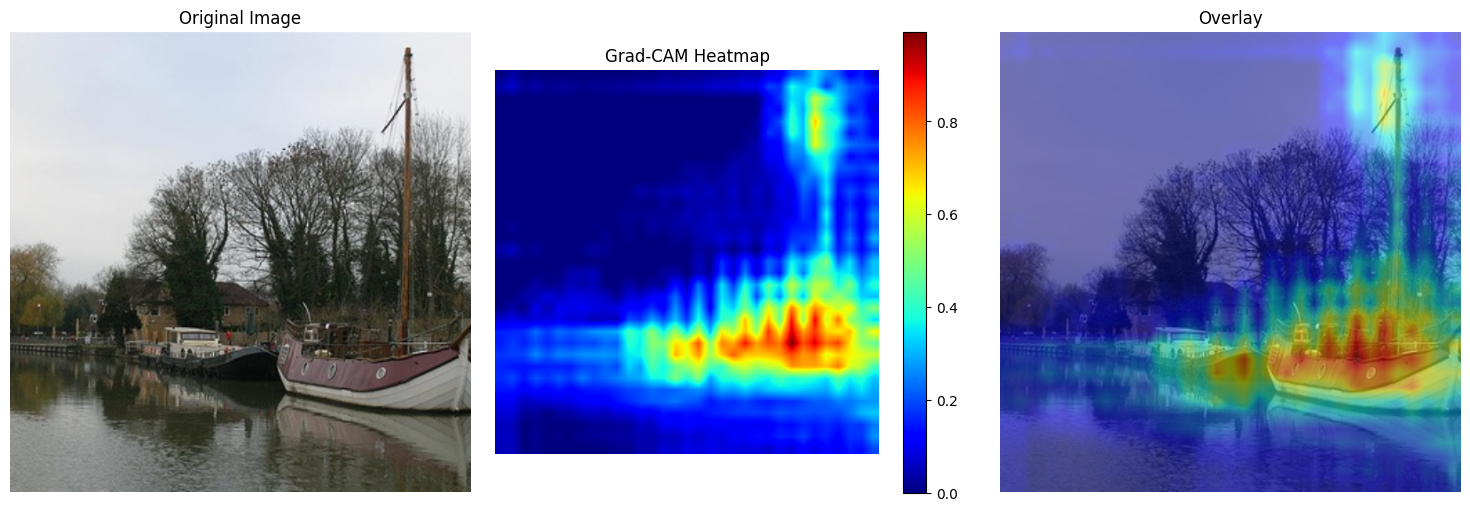

In [28]:
# Visualize Grad-CAM heatmap overlay
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Select the first image in the batch
img_idx = 3
original_img = scs_img[img_idx].permute(1, 2, 0).cpu().numpy()  # [H, W, C]
cam_heatmap = cam_upsampled[img_idx].detach().cpu().numpy()  # [H, W]

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# CAM heatmap
heatmap = axes[1].imshow(cam_heatmap, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap')
axes[1].axis('off')
plt.colorbar(heatmap, ax=axes[1])

# Overlay: blend original image with heatmap
# Convert heatmap to RGB using jet colormap
heatmap_colored = cm.jet(cam_heatmap)[:, :, :3]  # Remove alpha channel
# Blend with original image (alpha blending)
alpha = 0.5
overlay = original_img * (1 - alpha) + heatmap_colored * alpha
overlay = np.clip(overlay, 0, 1)  # Ensure values are in [0, 1]

axes[2].imshow(overlay)
axes[2].set_title('Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
pr_masks = apply_colormap(logits.argmax(dim=1, keepdim=True).to(torch.uint8),color_map=viz_ds.get_color_map_dict())
to_pil_image(pr_masks[4])

In [ ]:
segmodel.remove_handles()